# Semantic segmentation

Semantic segmentation assigns a label or class to each individual pixel of an image. There are several types of segmentation, and in the case of semantic segmentation, no distinction is made between unique instances of the same object. Both objects are given the same label (for example, "car" instead of "car-1" and "car-2"). Common real-world applications of semantic segmentation include training self-driving cars to identify pedestrians and important traffic information, identifying cells and abnormalities in medical imagery, and monitoring environmental changes from satellite imagery.

In [ ]:
!pip install datasets transformers[torch] evaluate

In [2]:
from huggingface_hub import notebook_login

notebook_login()

## Evaluate

In [7]:
import evaluate

metric = evaluate.load("mean_iou")

In [8]:
def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=14,
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()
        return metrics

## LPCV DATASET


In [9]:
#link drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#unpack dataset
! unzip /content/drive/MyDrive/LPCVC2023_Data/LPCVC_Train_Updated.zip
! unzip /content/drive/MyDrive/LPCVC2023_Data/LPCVC_Val.zip

In [11]:
from transformers import AutoImageProcessor, MobileNetV2ForSemanticSegmentation, Trainer, TrainingArguments
from PIL import Image
import torch
from matplotlib.colors import ListedColormap
import os
from torch.utils.data import Dataset
from torchvision import transforms
import random
import torchvision
import torch.nn.functional as F


def augmentation(image, label, angle_range=15, target_size=(512, 512)):
    #convert lable into PIL image
    label = Image.fromarray(label)

    #random horizontal flip
    if random.random() > 0.8:
        image = torchvision.transforms.functional.hflip(image)
        #print lable type
        label = torchvision.transforms.functional.hflip(label)

    #random vertical flip
    if random.random() > 0.5:
        image = torchvision.transforms.functional.vflip(image)
        label = torchvision.transforms.functional.vflip(label)

    #convert label into numpy array
    label = np.asarray(label)

    return image, label



class lpcv_dataset(Dataset):
    def __init__(self, image_folder, label_folder, image_processor, transform=None, augmentation=None):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.image_filenames = sorted(os.listdir(image_folder))  # Sort filenames
        self.transform = transform
        self.augmentation = augmentation
        self.image_processor = image_processor

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_filename = self.image_filenames[idx]
        image_path = os.path.join(self.image_folder, image_filename)

        # Generate corresponding label filename
        label_path = os.path.join(self.label_folder, image_filename)

        image = Image.open(image_path).convert("RGB")

        try:
            image = Image.open(image_path).convert("RGB")
        except FileNotFoundError as e:
            # If the file is not found, raise a FileNotFoundError exception.
            raise e
        label = np.asarray(Image.open(label_path))[:,:,0]

        if self.augmentation:
            image, label = self.augmentation(image, label)

        # Scale image pixel values to [0, 1] range
        image = np.array(image) / 255.0

        # Preprocess the image using the image_processor
        inputs = self.image_processor(images=image, return_tensors="pt")


        #remove the 3rd dimension from input
        inputs["pixel_values"] = inputs["pixel_values"].squeeze(0)

        return {"pixel_values": inputs["pixel_values"], "labels": torch.tensor(label, dtype=torch.long)}


categories = ["background", "avalanche",
              "building_undamaged", "building_damaged",
              "cracks/fissure/subsidence", "debris/mud/rock flow",
              "fire/flare", "flood/water/river/sea",
              "ice_jam_flow", "lava_flow",
              "person", "pyroclastic_flow",
              "road/railway/bridge", "vehicle"]

colors = ['black', 'white', 'pink', 'yellow', 'orange', 'brown',
          'red', 'blue', 'navy', 'orange', 'cyan', 'gray',
          'magenta']

#import changing initial resulution and number of classes
image_processor = AutoImageProcessor.from_pretrained("google/deeplabv3_mobilenet_v2_1.0_513",
                                                     num_labels=len(categories),
                                                     ignore_mismatched_sizes=True,
                                                     crop_size=(512, 512))

model = MobileNetV2ForSemanticSegmentation.from_pretrained("google/deeplabv3_mobilenet_v2_1.0_513",
                                                           num_labels=len(categories),
                                                           ignore_mismatched_sizes=True,
                                                           image_size=(512, 512))


transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

image_folder="LPCVC_Train_Updated/LPCVC_Train_Updated/LPCVC_Train_Updated/IMG/train"
label_folder="LPCVC_Train_Updated/LPCVC_Train_Updated/LPCVC_Train_Updated/GT_Updated/train"

val_folder="LPCVC_Val/LPCVC_Val/IMG/val"
val_label_folder="LPCVC_Val/LPCVC_Val/GT/val"

LPCV_dataset = lpcv_dataset(image_folder, label_folder, image_processor,  augmentation= augmentation)


Some weights of MobileNetV2ForSemanticSegmentation were not initialized from the model checkpoint at google/deeplabv3_mobilenet_v2_1.0_513 and are newly initialized because the shapes did not match:
- segmentation_head.classifier.convolution.weight: found shape torch.Size([21, 256, 1, 1]) in the checkpoint and torch.Size([14, 256, 1, 1]) in the model instantiated
- segmentation_head.classifier.convolution.bias: found shape torch.Size([21]) in the checkpoint and torch.Size([14]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train

1. Define training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments). don't remove unused columns because this'll drop the `image` column. Without the `image` column, you can't create `pixel_values`. Set `remove_unused_columns=False` to prevent this behavior! The only other required parameter is `output_dir` which specifies where to save your model. At the end of each epoch, the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) will evaluate the IoU metric and save the training checkpoint.
2. Pass the training arguments to [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, tokenizer, data collator, and `compute_metrics` function.
3. Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune the model.

In [16]:
import torch
import torch.nn as nn
import numpy as np

training_args = TrainingArguments(
    output_dir="lpcv_seg",
    learning_rate=6e-5,
    num_train_epochs=30,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=400,
    eval_steps=400,
    logging_steps=1,
    eval_accumulation_steps=5,
    remove_unused_columns=False,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=LPCV_dataset,
    eval_dataset=lpcv_dataset(val_folder, val_label_folder, image_processor),
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Per Category Iou,Per Category Accuracy
400,1.029900,1.144539,0.150317,0.229264,0.684636,"[0.7016834423401825, 0.0, 0.28392253175773663, 0.09630649211770352, 0.16489618177561766, 0.05923195228949304, 0.0, 0.47146079872020313, 0.0, nan, 0.0, 0.002537363927640351, 0.17407988046100897, 0.0]","[0.891422563505799, 0.0, 0.7160794493379222, 0.101650104427665, 0.20155241518296468, 0.08566222638071554, 0.0, 0.7801995050268263, 0.0, nan, 0.0, 0.002538359085235112, 0.20133152963007558, 0.0]"
800,1.294600,0.946253,0.151385,0.221747,0.698978,"[0.7200410800543089, 0.025577984693804623, 0.272186783532416, 0.03900872477465889, 0.1420562982408946, 0.13672818472813886, 0.0, 0.3747836709762802, 1.4597782434650593e-05, nan, 0.0, 0.0, 0.2576138826730331, 0.0]","[0.9197800777719178, 0.025581056237151574, 0.3936555737035525, 0.03917595636589459, 0.1525480793198657, 0.16772954472705784, 0.0, 0.8514708072975876, 1.4597782434650593e-05, nan, 0.0, 0.0, 0.33275562889985905, 0.0]"
1200,0.886900,0.900478,0.255317,0.346271,0.722986,"[0.7311911080696011, 0.1716353741804461, 0.32989770226558307, 0.2484733739307282, 0.20678309581325105, 0.16925674004774066, 0.026560396219635213, 0.43309262889720945, 0.4791539954039438, nan, 0.0, 0.1996331281686418, 0.3234492318785704, 0.0]","[0.8817514590505282, 0.1734977169471996, 0.5536498133348888, 0.26666168042981364, 0.2199222972903758, 0.30495278898499545, 0.026735171458080034, 0.8794234634009936, 0.5647817144933271, nan, 0.0, 0.19998287851911137, 0.43016977002783463, 0.0]"
1600,0.805600,0.730511,0.310581,0.389715,0.759494,"[0.7538928589848243, 0.25918801874572633, 0.4203485338620474, 0.2917137053557758, 0.22289503658523782, 0.1500749815626878, 0.08861529960760275, 0.624086456268012, 0.48451939021185103, nan, 0.0, 0.3968018568653773, 0.34541558718052773, 0.0]","[0.9269385933729979, 0.2666068145623601, 0.5690834086799277, 0.323866282726429, 0.23199974868520706, 0.27844356662715314, 0.08945714746397179, 0.7853752936779852, 0.7445501612243971, nan, 0.0, 0.4213536720599331, 0.42861443009823574, 0.0]"
2000,0.753400,0.809070,0.276196,0.377423,0.740779,"[0.7450525081446471, 0.08805507548598117, 0.39296675038083556, 0.17888143033371248, 0.23466648108570068, 0.16079006682931019, 0.03714210117676656, 0.6219865494576018, 0.5133743295405404, nan, 0.0, 0.25318448016278294, 0.3644475822818699, 0.0]","[0.8925789949539187, 0.08813412970942185, 0.6256571559820335, 0.18979883934004887, 0.24639981315291482, 0.4060874245051725, 0.03731593695118816, 0.8003825980603533, 0.8838065177476595, nan, 0.0, 0.25812424222515545, 0.47821461707899227, 0.0]"
2400,0.909000,0.735073,0.325849,0.410909,0.769776,"[0.7635658546626002, 0.40487164496967293, 0.3833268397798514, 0.2752089531995694, 0.2867291055853458, 0.019354003421208514, 0.16890635042927862, 0.5748136637050552, 0.6549805047839075, nan, 0.0, 0.41018196642738697, 0.29410209406700305, 0.0]","[0.936836241285118, 0.4435412622122596, 0.6115797993350055, 0.29433416172859234, 0.3084226650431367, 0.01980599690692518, 0.1729223045848531, 0.8637196946532967, 0.9040471540812156, nan, 0.0, 0.44469064868513, 0.3419148529297193, 0.0]"
2800,0.662200,0.696343,0.339802,0.398609,0.782702,"[0.7663761109958838, 0.1332027535954636, 0.4428707076945945, 0.35775923195424675, 0.3733786220955952, 0.24949901778334058, 0.07535404639899677, 0.6174965473057359, 0.5443824880761584, nan, 0.0, 0.4962856002887922, 0.3608184550398603, 0.0]","[0.9493652245312661, 0.13338632341294235, 0.6300075103540804, 0.4173944872618647, 0.41213577281689057, 0.31108969330720987, 0.0759392172499597, 0.6593100168039995, 0.5955570838172228, nan, 0.0, 0.5200351189445205, 0.4777004199984418, 0.0]"
3200,1.120200,1.635216,0.168407,0.232178,0.702578,"[0.6963172586859363, 0.011559652438449069, 0.22669839158942193, 0.05922256175168542, 0.06532726727054458, 0.0023358067869460536, 0.0, 0.509361415684211, 0.38727970470408707, nan, 0.0, 0.09125458640751972, 0.13993367687629527, 0.0]","[0

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label
Trainer is attempting to log a value of "[0.7016834423401825, 0.0, 0.28392253175773663, 0.09630649211770352, 0.16489618177561766, 0.05923195228949304, 0.0, 0.47146079872020313, 0.0, nan, 0.0, 0.002537363927640351, 0.17407988046100897, 0.0]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.891422563505799, 0.

TrainOutput(global_step=3840, training_loss=0.9817684325001513, metrics={'train_runtime': 5219.4936, 'train_samples_per_second': 5.868, 'train_steps_per_second': 0.736, 'total_flos': 3.647830622522573e+17, 'train_loss': 0.9817684325001513, 'epoch': 30.0})

Once training is completed, share your model to the Hub with the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method so everyone can use your model:

In [17]:
trainer.push_to_hub()

pytorch_model.bin:   0%|          | 0.00/10.4M [00:00<?, ?B/s]

'https://huggingface.co/gabryland/lpcv_seg/tree/main/'

https://huggingface.co/gabryland/lpcv_seg/tree/main/

## Inference

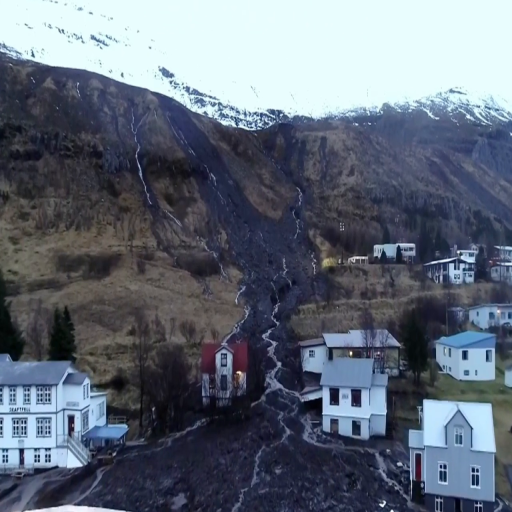

In [31]:
image = Image.open('/content/LPCVC_Val/LPCVC_Val/IMG/val/val_0001.png')
image

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available, otherwise use a CPU
encoding = image_processor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)

input to the model and return the `logits`:

In [33]:
model.eval()
outputs = model(pixel_values=pixel_values)

logits = outputs.logits.cpu()

rescale the logits to the original image size:

In [34]:
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)

pred_seg = upsampled_logits.argmax(dim=1)[0]

pred_seg

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [35]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51]]


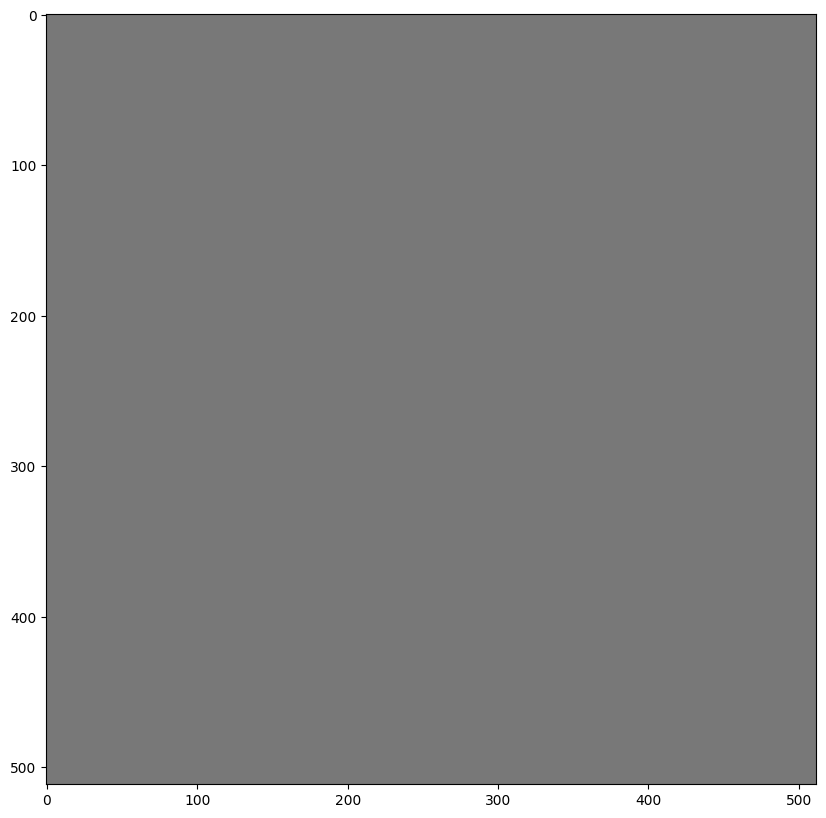

In [36]:
import matplotlib.pyplot as plt
import numpy as np

color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[pred_seg == label, :] = color
color_seg = color_seg[..., ::-1]  # convert to BGR

img = color_seg  # plot the image with the segmentation map
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()